## XGBoost


In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix


In [ ]:
df_test_id = pd.read_csv('Final_Test.csv')

In [ ]:
df = pd.read_csv('Final_Training.csv')
df_test = pd.read_csv('Final_Test.csv')

In [ ]:
# Define age groups
bins = [18, 30, 50, float('inf')]  # Define age bin edges
labels = ['18-30', '31-50', '50+']  # Labels for age groups

# Create a new column for Age Group
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)
df_test['Age_Group'] = pd.cut(df_test['Age'], bins=bins, labels=labels, right=True)

In [ ]:
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

In [ ]:
columns_to_remove_outliers = ['Travel_Distance', 'Departure_Delay_in_Mins','Arrival_Delay_in_Mins']

In [ ]:
for column in columns_to_remove_outliers:
    df = remove_outliers_iqr(df, column)

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns

In [ ]:
# Sort unique values for each categorical column and display
for col in categorical_cols:
    sorted_unique_values = sorted(df[col].unique())  # Sorting unique values
    print(f"Column: {col}")
    print(f"Unique Values (Sorted): {sorted_unique_values}\n")

Column: Gender
Unique Values (Sorted): ['Female', 'Male']

Column: Customer_Type
Unique Values (Sorted): ['Disloyal Customer', 'Loyal Customer']

Column: Type_Travel
Unique Values (Sorted): ['Business Travel', 'Personal Travel']

Column: Travel_Class
Unique Values (Sorted): ['Business', 'Eco']

Column: Seat_Comfort
Unique Values (Sorted): ['Acceptable', 'Excellent', 'Extremely Poor', 'Good', 'Needs Improvement', 'Poor']

Column: Seat_Class
Unique Values (Sorted): ['Green Car', 'Ordinary']

Column: Arrival_Time_Convenient
Unique Values (Sorted): ['Acceptable', 'Excellent', 'Extremely Poor', 'Good', 'Needs Improvement', 'Poor']

Column: Catering
Unique Values (Sorted): ['Acceptable', 'Excellent', 'Extremely Poor', 'Good', 'Needs Improvement', 'Poor']

Column: Platform_Location
Unique Values (Sorted): ['Convenient', 'Inconvenient', 'Manageable', 'Needs Improvement', 'Very Convenient', 'Very Inconvenient']

Column: Onboard_Wifi_Service
Unique Values (Sorted): ['Acceptable', 'Excellent', 'E

In [ ]:
df['Platform_Location'].replace('Very Convenient', 'Excellent', inplace=True)
df['Platform_Location'].replace('Convenient', 'Good', inplace=True)
df['Platform_Location'].replace('Manageable', 'Acceptable', inplace=True)
df['Platform_Location'].replace('Inconvenient', 'Poor', inplace=True)
df['Platform_Location'].replace('Very Inconvenient', 'Extremely Poor', inplace=True)

<ipython-input-79-4521a5d4a9a3>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Platform_Location'].replace('Very Convenient', 'Excellent', inplace=True)
<ipython-input-79-4521a5d4a9a3>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(va

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   ID                               94379 non-null  int64   
 1   Age                              94379 non-null  float64 
 2   Travel_Distance                  94379 non-null  int64   
 3   Departure_Delay_in_Mins          94379 non-null  float64 
 4   Arrival_Delay_in_Mins            94379 non-null  float64 
 5   Overall_Experience               94379 non-null  int64   
 6   Seat_Comfort                     94379 non-null  object  
 7   Seat_Class                       94379 non-null  object  
 8   Arrival_Time_Convenient          94379 non-null  object  
 9   Catering                         94379 non-null  object  
 10  Platform_Location                94379 non-null  object  
 11  Onboard_Wifi_Service             94379 non-null  object  
 12  Onbo

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns

In [ ]:
#df = pd.get_dummies(df, columns=['Gender','Customer_Type','Type_Travel','Travel_Class'])
#df_test = pd.get_dummies(df_test, columns=['Gender','Customer_Type','Type_Travel','Travel_Class'])
df = pd.get_dummies(df, columns=categorical_cols)
df_test = pd.get_dummies(df_test, columns=categorical_cols)

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])



In [ ]:
label_encoders_test = {}
for col in categorical_cols:
    label_encoders_test[col] = LabelEncoder()
    df_test[col] = label_encoders_test[col].fit_transform(df_test[col])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 100 columns):
 #   Column                                     Non-Null Count  Dtype   
---  ------                                     --------------  -----   
 0   ID                                         94379 non-null  int64   
 1   Age                                        94379 non-null  float64 
 2   Travel_Distance                            94379 non-null  int64   
 3   Departure_Delay_in_Mins                    94379 non-null  float64 
 4   Arrival_Delay_in_Mins                      94379 non-null  float64 
 5   Overall_Experience                         94379 non-null  int64   
 6   Age_Group                                  86350 non-null  category
 7   Gender_Female                              94379 non-null  bool    
 8   Gender_Male                                94379 non-null  bool    
 9   Customer_Type_Disloyal Customer            94379 non-null  bool    
 10  Customer_

In [ ]:
df_backup = df.copy()

In [ ]:
df_test_backup = df_test.copy()

In [ ]:
df['Departure_Delay_in_Mins'] = np.log1p(df['Departure_Delay_in_Mins'])

In [ ]:
df['Arrival_Delay_in_Mins'] = np.log1p(df['Arrival_Delay_in_Mins'])

In [ ]:
df['Travel_Distance'] = np.log1p(df['Travel_Distance'])

In [ ]:
mmscaler = MinMaxScaler()

In [ ]:
df['Age'] = mmscaler.fit_transform(df[['Age']])

In [ ]:
df_test['Departure_Delay_in_Mins'] = np.log1p(df_test['Departure_Delay_in_Mins'])

In [ ]:
df_test['Arrival_Delay_in_Mins'] = np.log1p(df_test['Arrival_Delay_in_Mins'])

In [ ]:
df_test['Travel_Distance'] = np.log1p(df_test['Travel_Distance'])

In [ ]:
mmscaler_test = MinMaxScaler()

In [ ]:
df_test['Age'] = mmscaler_test.fit_transform(df_test[['Age']])

In [ ]:
df = df.drop(columns=['Seat_Class', 'Departure_Delay_in_Mins','Travel_Distance','Age','Arrival_Delay_in_Mins'], errors='ignore')

In [ ]:
df_test = df_test.drop(columns=['Seat_Class', 'Departure_Delay_in_Mins','Travel_Distance','Age','Arrival_Delay_in_Mins'], errors='ignore')

In [ ]:
df.head()

,ID,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Overall_Experience,Age_Group,Gender_Female,Gender_Male,Customer_Type_Disloyal Customer,...,Cleanliness_Extremely Poor,Cleanliness_Good,Cleanliness_Needs Improvement,Cleanliness_Poor,Online_Boarding_Acceptable,Online_Boarding_Excellent,Online_Boarding_Extremely Poor,Online_Boarding_Good,Online_Boarding_Needs Improvement,Online_Boarding_Poor
0,98800001,52.0,272,0.0,5.0,0,50+,True,False,False,...,False,False,True,False,False,False,False,False,False,True
1,98800002,48.0,2200,9.0,0.0,0,31-50,False,True,False,...,False,True,False,False,False,False,False,True,False,False
2,98800003,43.0,1061,77.0,119.0,1,31-50,True,False,False,...,False,False,False,False,False,True,False,False,False,False
3,98800004,44.0,780,13.0,18.0,0,31-50,True,False,False,...,False,False,False,False,True,False,False,False,False,False
4,98800005,50.0,1981,0.0,0.0,1,31-50,True,False,False,...,False,True,False,False,False,False,False,True,False,False


In [ ]:
df['Total_Delay'] = (df['Departure_Delay_in_Mins'] + df['Arrival_Delay_in_Mins'])

In [ ]:
survey_columns = [col for col in df.columns if col.startswith(('Seat_', 'Onboard_', 'Online_'))]
survey_columns

['Seat_Comfort',
 'Seat_Class',
 'Onboard_Wifi_Service',
 'Onboard_Entertainment',
 'Online_Support',
 'Onboard_Service',
 'Online_Boarding']

In [ ]:
df['Overall_Rating'] = round((df['Onboard_Wifi_Service']+ df['Arrival_Time_Convenient'] +
  df['Ease_of_Online_Booking'] + df['Platform_Location'] + df['Catering']+ df['Online_Support'] + df['Ease_of_Online_Booking'] +
  df['Seat_Comfort'] + df['Onboard_Entertainment'] + df['Online_Boarding'] + df['Legroom'] +
  df['Baggage_Handling'] + df['CheckIn_Service'] + df['Onboard_Service'] + df['Cleanliness'])/15,1)

KeyError: 'Onboard_Wifi_Service'

In [ ]:
df_test['Total_Delay'] = (df_test['Departure_Delay_in_Mins'] + df_test['Arrival_Delay_in_Mins'])

In [ ]:
df_test['Overall_Rating'] = round((df_test['Onboard_Wifi_Service']+ df_test['Arrival_Time_Convenient'] +
  df_test['Ease_of_Online_Booking'] + df_test['Platform_Location'] + df_test['Catering']+ df_test['Online_Support'] + df_test['Ease_of_Online_Booking'] +
  df_test['Seat_Comfort'] + df_test['Onboard_Entertainment'] + df_test['Online_Boarding'] + df_test['Legroom'] +
  df_test['Baggage_Handling'] + df_test['CheckIn_Service'] + df_test['Onboard_Service'] + df_test['Cleanliness'])/15,1)

In [ ]:
# Define age groups
bins = [0, 15, 30, 60, float('inf')]  # Define delay time bin edges
labels = ['On Time', 'Minor Delay', 'Moderate Delay', 'Major Delay']  # Labels for delay groups

# Create a new column for Age Group
df['Status_Code'] = pd.cut(df['Total_Delay'], bins=bins, labels=labels, right=True)
df_test['Status_Code'] = pd.cut(df_test['Total_Delay'], bins=bins, labels=labels, right=True)

In [ ]:
df['Delayed'] = df['Total_Delay'].apply(lambda x: 1 if x > 15 else 0)
df_test['Delayed'] = df_test['Total_Delay'].apply(lambda x: 1 if x > 15 else 0)

In [ ]:
df['Status_Code'] = df['Status_Code'].fillna("On Time")
df_test['Status_Code'] = df_test['Status_Code'].fillna("On Time")

In [ ]:
df_test['Status_Code'].value_counts()

,count
Status_Code,
On Time,24639
Major Delay,4904
Minor Delay,3039
Moderate Delay,3020


In [ ]:
df['Inflight_Comfort'] = (df['Onboard_Wifi_Service'] + df['Seat_Comfort'] + df['Onboard_Entertainment'] + df['Legroom'] + + df['Cleanliness'])/5
df_test['Inflight_Comfort'] = (df_test['Onboard_Wifi_Service'] + df_test['Seat_Comfort'] + df_test['Onboard_Entertainment'] + df_test['Legroom'] + + df['Cleanliness'])/5
df['Preboarding_Comfort'] = (df['Online_Boarding'] + df['Baggage_Handling'] + df['CheckIn_Service'] + df['Onboard_Service'])/4
df_test['Preboarding_Comfort'] = (df_test['Online_Boarding'] + df_test['Baggage_Handling'] + df_test['CheckIn_Service'] + df_test['Onboard_Service'])/4

In [ ]:
df['Status_Code'] = LabelEncoder().fit_transform(df['Status_Code'])
df_test['Status_Code'] = LabelEncoder().fit_transform(df_test['Status_Code'])

In [ ]:
df=pd.get_dummies(df, columns=['Age_Group','Status_Code'])
df_test=pd.get_dummies(df_test, columns=['Age_Group','Status_Code'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Columns: 103 entries, ID to Status_Code_Major Delay
dtypes: bool(95), float64(4), int64(4)
memory usage: 14.3 MB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35602 entries, 0 to 35601
Columns: 102 entries, ID to Status_Code_Major Delay
dtypes: bool(95), float64(4), int64(3)
memory usage: 5.1 MB


In [ ]:
missing_cols = set(df.columns) - set(df_test.columns)

In [ ]:
missing_cols.remove('Overall_Experience')

In [ ]:
df = df.drop(columns=missing_cols)

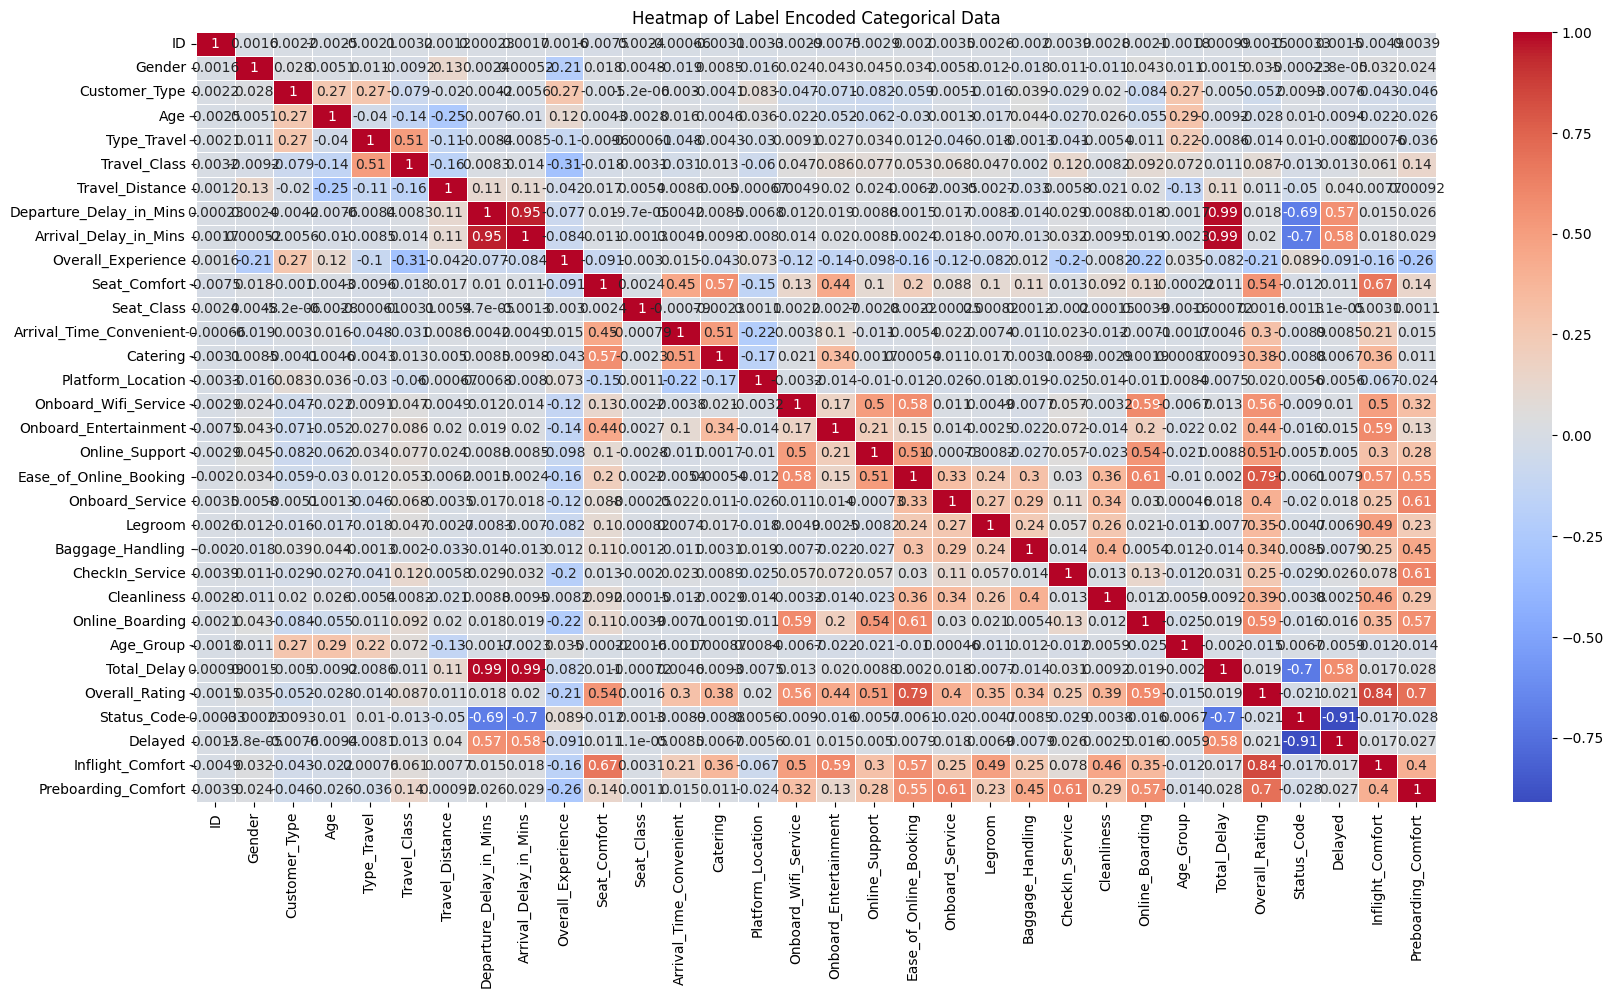

In [ ]:
# Compute correlation matrix and plot heatmap
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Heatmap of Label Encoded Categorical Data")
plt.show()

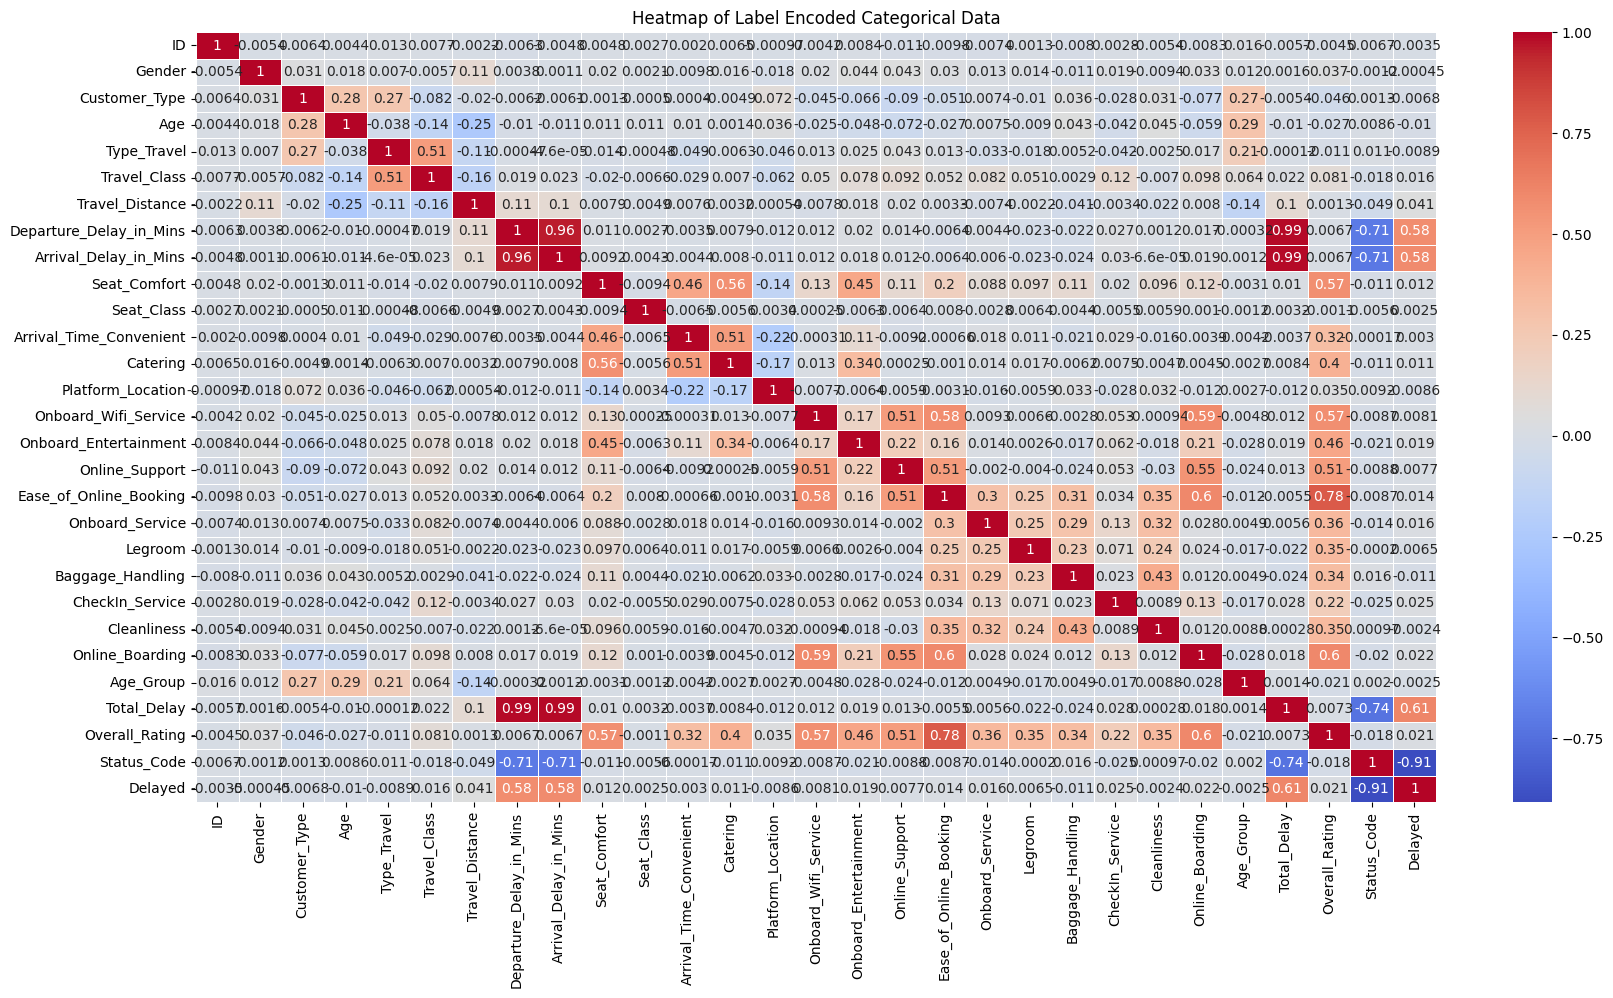

In [ ]:
# Compute correlation matrix and plot heatmap
plt.figure(figsize=(20,10))
sns.heatmap(df_test.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Heatmap of Label Encoded Categorical Data")
plt.show()

In [ ]:
# Split data into features (X) and target (y)
X = df.drop(columns=["Overall_Experience", "ID"])
y = df["Overall_Experience"]
X_test = df_test.drop(columns=["ID"])

In [ ]:
# Standardize numerical features
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Split data into train and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV



In [ ]:
xgb = XGBClassifier()
param_grid = {
    'n_estimators': [300, 500],
    'learning_rate': [0.02, 0.05],
    'max_depth': [9, 11],
    'min_child_weight': [1,2],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'gamma': [0.1, 0.2]
}

grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 11, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.9}


In [ ]:
# Initialize XGBoost classifier
xgb_clf = XGBClassifier(
    objective='binary:logistic',  # Binary classification
    eval_metric='logloss',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=11,
    min_child_weight=1,
    gamma=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)
# Define parameter grid
param_grid = {
    'alpha': [1],  # L1 regularization
    'lambda': [0]  # L2 regularization
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
y_pred = grid_search.best_estimator_.predict(X_val)
print("Test Accuracy:", accuracy_score(y_val, y_pred))



Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'alpha': 1, 'lambda': 0}
Test Accuracy: 0.9552871371053189


In [ ]:
best_params = grid_search.best_params_
final_model = XGBClassifier(
    objective='binary:logistic',  # Binary classification
    eval_metric='logloss',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=11,
    min_child_weight=1,
    gamma=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42#,
    #**best_params
)

# Train the model
final_model.fit(X_train, y_train)

# Make predictions on validation set
y_pred = final_model.predict(X_val)
y_pred_proba = final_model.predict_proba(X_val)[:, 1]  # Get probability scores for AUC

# Evaluate model performance
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred))





Accuracy: 0.9553
F1 Score: 0.9587
ROC-AUC Score: 0.9934

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      6418
           1       0.97      0.95      0.96      7739

    accuracy                           0.96     14157
   macro avg       0.95      0.96      0.95     14157
weighted avg       0.96      0.96      0.96     14157



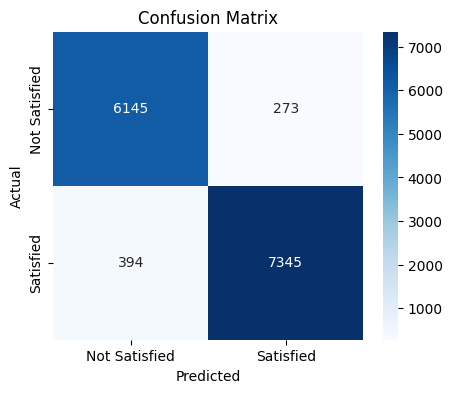

In [ ]:
# Confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Not Satisfied', 'Satisfied'], yticklabels=['Not Satisfied', 'Satisfied'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Standardize numerical features
#test_scaled = scaler.transform(X_test)

# Predict on test data
test_predictions = final_model.predict(X_test)



In [ ]:
df_test['ID']=label_encoders_test['ID'].inverse_transform(df_test['ID'])

In [ ]:
# Create submission file
submission = pd.DataFrame({'ID': df_test_id['ID'], 'Overall_Experience': test_predictions})
submission.to_csv("submission.csv", index=False)

print("Submission file 'submission.csv' created successfully!")

Submission file 'submission.csv' created successfully!


In [ ]:
submission

,ID,Overall_Experience
0,99900001,1
1,99900002,1
2,99900003,1
3,99900004,0
4,99900005,1
...,...,...
35597,99935598,0
35598,99935599,1
35599,99935600,1
35600,99935601,1


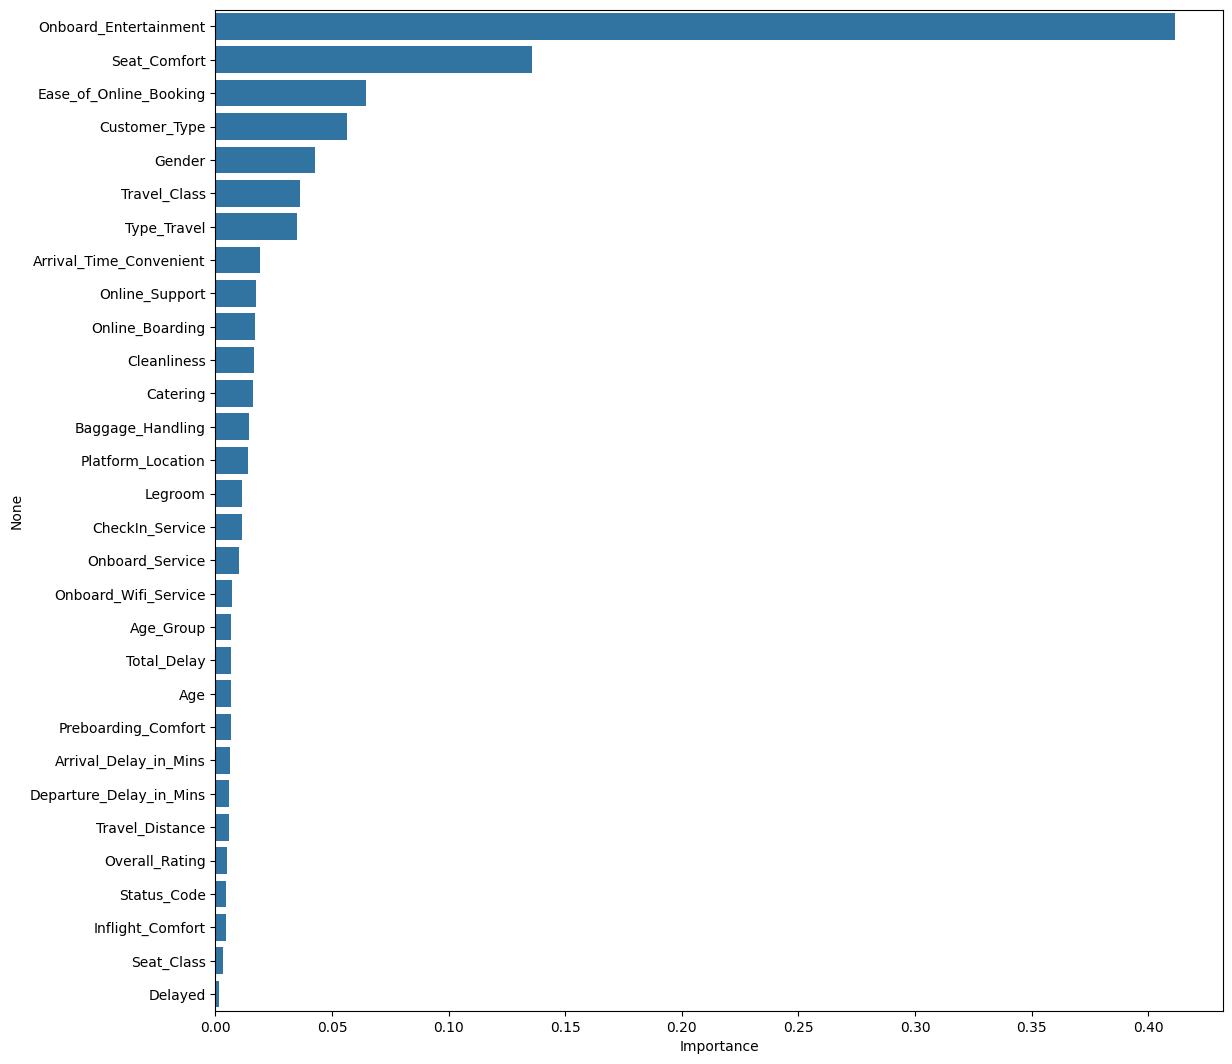

In [ ]:
importances = final_model.feature_importances_

columns = X.columns

importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

sns.barplot(x= importance_df.Importance, y=importance_df.index);

In [ ]:
from sklearn.feature_selection import RFE

final_rfe_model = XGBClassifier(
    objective='binary:logistic',  # Binary classification
    eval_metric='logloss',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=11,
    min_child_weight=1,
    gamma=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42#,
    #**best_params
)
rfe=RFE(final_rfe_model,n_features_to_select=7)
rfe.fit(X_train,y_train)



RFE(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=0.9, device=None,
                            early_stopping_rounds=None,
                            enable_categorical=False, eval_metric='logloss',
                            feature_types=None, gamma=0.1, grow_policy=None,
                            importance_type=None, interaction_constraints=None,
                            learning_rate=0.05, max_bin=None,
                            max_cat_threshold=None, max_cat_to_onehot=None,
                            max_delta_step=None, max_depth=11, max_leaves=None,
                            min_child_weight=1, missing=nan,
                            monotone_constraints=None, multi_strategy=None,
                            n_estimators=500, n_jobs=None,
                            num_parallel_tree=None, random_state=42, ...),
    n_features_to_select=7)

In [ ]:
# Make predictions on validation set
y_pred = rfe.predict(X_val)
y_pred_proba = rfe.predict_proba(X_val)[:, 1]  # Get probability scores for AUC

# Evaluate model performance
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred))

Accuracy: 0.9129
F1 Score: 0.9206
ROC-AUC Score: 0.9742

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.90      6418
           1       0.92      0.92      0.92      7739

    accuracy                           0.91     14157
   macro avg       0.91      0.91      0.91     14157
weighted avg       0.91      0.91      0.91     14157



In [ ]:
from sklearn.feature_selection import mutual_info_classif
mi_scores = mutual_info_classif(X_train, y_train)
mi_feature_importance = pd.Series(mi_scores, name="MI Scores", index=X.columns).sort_values(ascending=False)
print(mi_feature_importance)

Onboard_Entertainment      0.231225
Seat_Comfort               0.140598
Ease_of_Online_Booking     0.110015
Online_Support             0.095577
Online_Boarding            0.066249
Onboard_Service            0.064654
Legroom                    0.057142
Overall_Rating             0.055287
Travel_Class               0.051807
Cleanliness                0.051162
Baggage_Handling           0.049236
Customer_Type              0.042500
CheckIn_Service            0.041677
Catering                   0.034155
Onboard_Wifi_Service       0.032550
Travel_Distance            0.027310
Gender                     0.027134
Age                        0.024274
Platform_Location          0.012634
Type_Travel                0.008418
Departure_Delay_in_Mins    0.006839
Arrival_Delay_in_Mins      0.005490
Seat_Class                 0.005321
Total_Delay                0.005121
Arrival_Time_Convenient    0.001820
Name: MI Scores, dtype: float64


In [ ]:
!pip install Boruta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 4.1 MB/s eta 0:00:00


In [ ]:
from boruta import BorutaPy
boruta = BorutaPy(final_rfe_model, n_estimators='auto', verbose=2, random_state=42)
boruta.fit(X_train, y_train)

sel_features = X.columns[boruta.support_]
print("Selected Features:", sel_features)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	24
Tentative: 	1
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	24
Tentative: 	0
Rejected: 	1


BorutaPy finished running.

Iteration: 	10 / 100
Confirmed: 	24
Tentative: 	0
Rejected: 	1
Selected Features: Index(['Gender', 'Customer_Type', 'Age', 'Type_Travel', 'Travel_Class',
       'Travel_Distance', 'Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins',
       'Seat_Comfort', 'Arrival_Time_Convenient', 'Catering',
       'Platform_Location', 'Onboard_Wifi_Service', 'Onboard_Entertainment',
       'Online_Support', 'Ease_of_Online_